# Bag of N Words Model

In [10]:
import spacy
import pandas as pd
import seaborn as sn
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [33]:
v = CountVectorizer()
v.fit(["Thor Hathodawala is looking for a job"])
v.vocabulary_

{'thor': 5, 'hathodawala': 1, 'is': 2, 'looking': 4, 'for': 0, 'job': 3}

In [34]:
v = CountVectorizer(ngram_range=(1,2))
v.fit(["Thor Hathodawala is looking for a job"])
v.vocabulary_

{'thor': 9,
 'hathodawala': 2,
 'is': 4,
 'looking': 7,
 'for': 0,
 'job': 6,
 'thor hathodawala': 10,
 'hathodawala is': 3,
 'is looking': 5,
 'looking for': 8,
 'for job': 1}

In [35]:
v = CountVectorizer(ngram_range=(1,3))
v.fit(["Thor Hathodawala is looking for a job"])
v.vocabulary_

{'thor': 12,
 'hathodawala': 2,
 'is': 5,
 'looking': 9,
 'for': 0,
 'job': 8,
 'thor hathodawala': 13,
 'hathodawala is': 3,
 'is looking': 6,
 'looking for': 10,
 'for job': 1,
 'thor hathodawala is': 14,
 'hathodawala is looking': 4,
 'is looking for': 7,
 'looking for job': 11}

We will not take a simple collection of text documents, preprocess them to remove stop words, lemmatize etc and then generate bag of 1 grams and 2 grams from it



In [36]:
corpus = [
    "Thor ate pizza",
    "Loki is tall",
    "Loki is eating pizza"
]

In [37]:
nlp = spacy.load("en_core_web_sm")

def preProcessing(text):
    doc = nlp(text)
    filtered_text = []

    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_text.append(token.lemma_)

    return " ".join(filtered_text)

preProcessing("Thor ate pizza.")


'thor eat pizza'

In [38]:
corpus_preprocessed = [preProcessing(text) for text in corpus]
corpus_preprocessed

['thor eat pizza', 'Loki tall', 'Loki eat pizza']

In [39]:
v = CountVectorizer(ngram_range=(1,2))
v.fit(corpus_preprocessed)
v.vocabulary_

{'thor': 7,
 'eat': 0,
 'pizza': 5,
 'thor eat': 8,
 'eat pizza': 1,
 'loki': 2,
 'tall': 6,
 'loki tall': 4,
 'loki eat': 3}

In [40]:
v.transform(["Thor eat pizza"]).toarray()

array([[1, 1, 0, 0, 0, 1, 0, 1, 1]], dtype=int64)

In [41]:
v.transform(["Hulk eat pizza"]).toarray()

array([[1, 1, 0, 0, 0, 1, 0, 0, 0]], dtype=int64)

In [42]:
df = pd.read_json("Sample CSV/news_dataset.json")
df.head()

,text,category
0,Watching Schrödinger's Cat Die University of C...,SCIENCE
1,WATCH: Freaky Vortex Opens Up In Flooded Lake,SCIENCE
2,Entrepreneurs Today Don't Need a Big Budget to...,BUSINESS
3,These Roads Could Recharge Your Electric Car A...,BUSINESS
4,Civilian 'Guard' Fires Gun While 'Protecting' ...,CRIME


In [43]:
df.category.value_counts()

category
BUSINESS    4254
SPORTS      4167
CRIME       2893
SCIENCE     1381
Name: count, dtype: int64

In [44]:
min_samples = 1381
df_Business = df[df.category=="BUSINESS"].sample(min_samples,random_state=2022)
df_Sports = df[df.category=="SPORTS"].sample(min_samples,random_state=2022)
df_Crime = df[df.category=="CRIME"].sample(min_samples,random_state=2022)
df_Science = df[df.category=="SCIENCE"].sample(min_samples,random_state=2022)

In [45]:
df_balanced = pd.concat([df_Business, df_Crime, df_Science, df_Sports], axis=0)
df_balanced.category.value_counts()

category
BUSINESS    1381
CRIME       1381
SCIENCE     1381
SPORTS      1381
Name: count, dtype: int64

In [46]:
df_balanced['category_num'] = df_balanced['category'].map({
    'BUSINESS': 0,
    'SPORTS': 1, 
    'CRIME': 2, 
    'SCIENCE': 3
})
df_balanced.head()

,text,category,category_num
11967,GCC Business Leaders Remain Confident in the F...,BUSINESS,0
2912,From the Other Side; an Honest Review from Emp...,BUSINESS,0
3408,"Mike McDerment, CEO of FreshBooks, Talks About...",BUSINESS,0
502,How to Market Your Business While Traveling th...,BUSINESS,0
5279,How to Leverage Intuition in Decision-making I...,BUSINESS,0


In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced.text,
    df_balanced.category_num,
    test_size=0.2,
    random_state=2022,
    stratify=df_balanced.category_num
)
print(X_train.shape)
X_train.head()

(4419,)


7589     Ovulating Women Prefer Images of Penetration O...
10442    Scientists Discover Spooky Influence On Baby N...
8792     Olympic Race Walker Steps Up To Propose To His...
1733     Beloved Bipedal Bear Named Pedals Believed Kil...
2526     Elizabeth Smart Gave Birth To Baby Girl, Fathe...
Name: text, dtype: object

In [48]:
y_test.value_counts()

category_num
1    277
0    276
3    276
2    276
Name: count, dtype: int64

In [49]:
clf = Pipeline([
    ("vectorizer_bow",CountVectorizer()),
    ("Multi NB", MultinomialNB())
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.75      0.87      0.81       276
           1       0.93      0.80      0.86       277
           2       0.83      0.90      0.86       276
           3       0.90      0.80      0.85       276

    accuracy                           0.84      1105
   macro avg       0.85      0.84      0.84      1105
weighted avg       0.85      0.84      0.84      1105



In [50]:
clf = Pipeline([
    ("vectorizer_bow",CountVectorizer(ngram_range=(1,2))),
    ("Multi NB", MultinomialNB())
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.69      0.90      0.78       276
           1       0.95      0.74      0.83       277
           2       0.82      0.88      0.85       276
           3       0.92      0.78      0.84       276

    accuracy                           0.82      1105
   macro avg       0.85      0.82      0.83      1105
weighted avg       0.85      0.82      0.83      1105



In [51]:
clf = Pipeline([
    ("vectorizer_bow",CountVectorizer(ngram_range=(1,3))),
    ("Multi NB", MultinomialNB())
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.67      0.91      0.77       276
           1       0.96      0.73      0.83       277
           2       0.83      0.87      0.85       276
           3       0.93      0.76      0.83       276

    accuracy                           0.82      1105
   macro avg       0.84      0.82      0.82      1105
weighted avg       0.84      0.82      0.82      1105



In [52]:
X_test[:5]

3716     African Nation Slaps Exxon With Fine Nearly 7 ...
608      These Cringe-Worthy Stories Show It Can Be Har...
11172    LISTEN: The Accidental Discovery That Proved T...
1346     Build Loyalty -- The Cost -- $00.00 Remember y...
1356     Man Killed By Michigan Police Wasn't Targeting...
Name: text, dtype: object

In [53]:
y_test[:5]

3716     0
608      3
11172    3
1346     0
1356     2
Name: category_num, dtype: int64

In [54]:
y_pred[:5]

array([0, 0, 3, 0, 2], dtype=int64)

In [59]:
df_balanced["preprocessed_text"] = df_balanced.text.apply(preProcessing)
df_balanced.head()

,text,category,category_num,preprocessed_text
11967,GCC Business Leaders Remain Confident in the F...,BUSINESS,0,GCC Business Leaders remain Confident Face Reg...
2912,From the Other Side; an Honest Review from Emp...,BUSINESS,0,Honest Review employee wake morning love impor...
3408,"Mike McDerment, CEO of FreshBooks, Talks About...",BUSINESS,0,Mike McDerment ceo FreshBooks Talks give build...
502,How to Market Your Business While Traveling th...,BUSINESS,0,market business travel World recently amazing ...
5279,How to Leverage Intuition in Decision-making I...,BUSINESS,0,Leverage intuition decision making feel safe r...


In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced.preprocessed_text,
    df_balanced.category_num,
    test_size=0.2,
    random_state=2022,
    stratify=df_balanced.category_num
)

clf = Pipeline([
    ("vectorizer_bow",CountVectorizer(ngram_range=(1,2))),
    ("Multi NB", MultinomialNB())
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       276
           1       0.92      0.82      0.87       277
           2       0.83      0.92      0.87       276
           3       0.90      0.81      0.85       276

    accuracy                           0.86      1105
   macro avg       0.86      0.86      0.86      1105
weighted avg       0.86      0.86      0.86      1105



If you compare above classification report for (1,2) gram with the one from unprocessed text, you will find some improvement in the model that uses preprocessed cleaned up text. Hence we can conclude that for this particular problem using preprocessing (removing stop words, lemmatization) is improving the performance of the model

In [67]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[243,   8,  17,   8],
       [ 10, 228,  29,  10],
       [ 15,   2, 253,   6],
       [ 36,   9,   7, 224]], dtype=int64)

Text(20.72222222222222, 0.5, 'Truth')

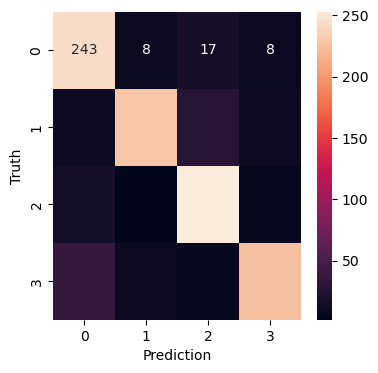

In [68]:
plt.figure(figsize = (4,4))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')

# Exercise

Fake news refers to misinformation or disinformation in the country which is spread through word of mouth and more recently through digital communication such as What's app messages, social media posts, etc.

Fake news spreads faster than Real news and creates problems and fear among groups and in society.

We are going to address these problems using classical NLP techniques and going to classify whether a given message/ text is Real or Fake Message.

You will use a Bag of n-grams to pre-process the text and apply different classification algorithms.

Sklearn CountVectorizer has the inbuilt implementations for Bag of Words.

### About Data: Fake News Detection
https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset

This data consists of two columns. - Text - label

Text is the statements or messages regarding a particular event/situation.

label feature tells whether the given Text is Fake or Real.

As there are only 2 classes, this problem comes under the Binary Classification

In [5]:
df = pd.read_csv("Sample CSV/Fake_Real_Data.csv")
df.head()

,Text,label
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake
1,U.S. conservative leader optimistic of common ...,Real
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real
3,Court Forces Ohio To Allow Millions Of Illega...,Fake
4,Democrats say Trump agrees to work on immigrat...,Real


In [6]:
df.label.value_counts()

label
Fake    5000
Real    4900
Name: count, dtype: int64

In [7]:
df["Label_Value"] = df["label"].map({
    'Fake': 0,
    'Real': 1
})

df.head()

,Text,label,Label_Value
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake,0
1,U.S. conservative leader optimistic of common ...,Real,1
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real,1
3,Court Forces Ohio To Allow Millions Of Illega...,Fake,0
4,Democrats say Trump agrees to work on immigrat...,Real,1


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    df.Text,
    df.Label_Value,
    test_size=0.2,
    random_state=2024,
    stratify=df.Label_Value
)

print(X_train.shape)
X_train.head()

(7920,)


5648    House Democrats seek documents on former Trump...
1134    Russian diplomat says U.S. stance on Syria 'a ...
3654    Congressional office to release House healthca...
5105    New Wall Street candidates emerge to test Trum...
8490     ‘Calexit’ Is Really A Thing, Might Mean Actua...
Name: Text, dtype: object

In [13]:
vectorizer = CountVectorizer(ngram_range=(1, 3)) 
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=10, metric='euclidean')
knn.fit(X_train_vec, y_train)

y_pred = knn.predict(X_test_vec)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.49      0.65      1000
           1       0.65      0.98      0.78       980

    accuracy                           0.73      1980
   macro avg       0.80      0.73      0.71      1980
weighted avg       0.80      0.73      0.71      1980

